In [1]:
#import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
# from keras.models import Sequential
# from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Bidirectional

In [2]:
# Read the dataset
df = pd.read_csv('../Dataset/VCB-Historical-Data_Group-9.csv',index_col='Date', parse_dates=True)
df.dropna() #Drop missing value
df = df.sort_values(by='Date', ascending=True)
df =df.reset_index(drop=True) #Reset the index
print(df)

       Price    Open    High     Low     Vol. Change %
0     47,765  46,844  47,765  46,690  910.43K    2.81%
1     48,226  47,765  48,379  47,765    1.72M    0.97%
2     48,379  48,226  48,994  47,995    2.01M    0.32%
3     48,149  48,456  48,610  47,535    1.38M   -0.48%
4     48,456  48,149  48,994  48,072    2.42M    0.64%
...      ...     ...     ...     ...      ...      ...
1308  90,200  90,400  90,600  89,700    1.06M    0.00%
1309  90,700  89,800  90,700  89,800    1.35M    0.55%
1310  89,800  90,800  91,000  89,800    1.19M   -0.99%
1311  88,600  89,500  89,700  88,500    2.36M   -1.34%
1312  87,200  88,700  89,000  87,200    3.92M   -1.58%

[1313 rows x 6 columns]


In [3]:
print(df.dtypes)

Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object


In [4]:
# Hàm chuyển đổi
def convert_str_to_number(str):
    return float(str.replace(',', ''))

def convert_change_to_number(change_str):
    return float(change_str.strip('%')) / 100

def convert_volume_to_number(volume_str):
    factor = {'K': 1000, 'M': 1000000, 'B': 1000000000}
    return int(float(volume_str[:-1]) * factor[volume_str[-1]]) if volume_str[-1] in factor else int(volume_str)

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'], df['Open'], df['High'], df['Low'] = [df[col].apply(convert_str_to_number) for col in ['Price', 'Open', 'High', 'Low']]
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

print(df)
df.describe()

        Price     Open     High      Low     Vol.  Change %
0     47765.0  46844.0  47765.0  46690.0   910430    0.0281
1     48226.0  47765.0  48379.0  47765.0  1720000    0.0097
2     48379.0  48226.0  48994.0  47995.0  2009999    0.0032
3     48149.0  48456.0  48610.0  47535.0  1380000   -0.0048
4     48456.0  48149.0  48994.0  48072.0  2420000    0.0064
...       ...      ...      ...      ...      ...       ...
1308  90200.0  90400.0  90600.0  89700.0  1060000    0.0000
1309  90700.0  89800.0  90700.0  89800.0  1350000    0.0055
1310  89800.0  90800.0  91000.0  89800.0  1190000   -0.0099
1311  88600.0  89500.0  89700.0  88500.0  2360000   -0.0134
1312  87200.0  88700.0  89000.0  87200.0  3920000   -0.0158

[1313 rows x 6 columns]


,Price,Open,High,Low,Vol.,Change %
count,1313.000000,1313.000000,1313.000000,1313.000000,1.313000e+03,1313.000000
mean,72471.978675,72424.153085,73233.866717,71622.597867,1.361500e+06,0.000628
std,11823.011892,11856.644405,11887.268082,11751.982547,7.560500e+05,0.017210
min,43925.000000,43925.000000,44847.000000,43465.000000,1.804900e+05,-0.149200
25%,63760.000000,63892.000000,64606.000000,63336.000000,8.581200e+05,-0.008400
50%,73238.000000,73316.000000,74167.000000,72387.000000,1.210000e+06,0.000000
75%,80900.000000,80694.000000,81755.000000,79819.000000,1.700000e+06,0.008900
max,97400.000000,98500.000000,100500.000000,97300.000000,8.010000e+06,0.069200


In [5]:
df1=df.reset_index()['Price']
df1

0       47765.0
1       48226.0
2       48379.0
3       48149.0
4       48456.0
         ...   
1308    90200.0
1309    90700.0
1310    89800.0
1311    88600.0
1312    87200.0
Name: Price, Length: 1313, dtype: float64

In [6]:
# 3. Split into train and test sets
train_size = int(0.8 * len(df))
test_size = int(0.1 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
train_data

,Price,Open,High,Low,Vol.,Change %
0,47765.0,46844.0,47765.0,46690.0,910430,0.0281
1,48226.0,47765.0,48379.0,47765.0,1720000,0.0097
2,48379.0,48226.0,48994.0,47995.0,2009999,0.0032
3,48149.0,48456.0,48610.0,47535.0,1380000,-0.0048
4,48456.0,48149.0,48994.0,48072.0,2420000,0.0064
...,...,...,...,...,...,...
1045,78747.0,76207.0,78916.0,76037.0,1770000,0.0356
1046,78154.0,78747.0,79509.0,78154.0,665380,-0.0075
1047,77900.0,77815.0,78747.0,77561.0,492950,-0.0033
1048,77053.0,77900.0,77985.0,77053.0,597110,-0.0109


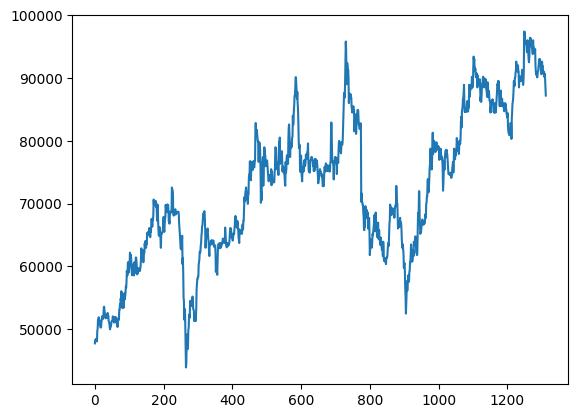

In [7]:
plt.plot(df1)

In [8]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [9]:
# df1.shape
print(df1)

[[0.07180926]
 [0.08043011]
 [0.08329126]
 ...
 [0.85787751]
 [0.83543712]
 [0.80925666]]


In [10]:
# 4. split the data into train and test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size 

train_data = df1[0:train_size,:]
test_data = df1[train_size:len(df1),:1]

In [11]:
#Training process
# a. convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

# b. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [12]:
print(X_train)

[[0.07180926 0.08043011 0.08329126 ... 0.31306218 0.31164095 0.28291725]
 [0.08043011 0.08329126 0.07899018 ... 0.31164095 0.28291725 0.29439925]
 [0.08329126 0.07899018 0.08473118 ... 0.28291725 0.29439925 0.30588125]
 ...
 [0.76201964 0.76835905 0.76043011 ... 0.82982702 0.85226741 0.82234689]
 [0.76835905 0.76043011 0.76201964 ... 0.85226741 0.82234689 0.78681627]
 [0.76043011 0.76201964 0.76201964 ... 0.82234689 0.78681627 0.77746611]]


In [13]:
# 8. Define GRU Model
model = xgb.XGBRegressor(
             colsample_bynode=1, colsample_bytree=1, gamma=0.01,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1, n_estimators=400,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42)

NameError: name 'xgb' is not defined

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=1, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.01, grow_policy=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=0, max_depth=8,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=1, nthread=None, num_parallel_tree=None, ...)

In [ ]:
# 7. Dự báo dữ liệu test, val
y_pred=model.predict(X_test)
y_pred

array([0.58275133, 0.58275133, 0.5927183 , 0.6188645 , 0.6504762 ,
       0.661679  , 0.661679  , 0.661679  , 0.661679  , 0.632717  ,
       0.6215142 , 0.5970137 , 0.5970137 , 0.5970137 , 0.5970137 ,
       0.5970137 , 0.57154256, 0.5793792 , 0.5762967 , 0.58275133,
       0.58275133, 0.61456907, 0.6215142 , 0.6188645 , 0.6188645 ,
       0.6478265 , 0.6591052 , 0.632717  , 0.6215142 , 0.6504762 ,
       0.68516874, 0.68516874, 0.661679  , 0.632717  , 0.6504762 ,
       0.661679  , 0.632717  , 0.6188645 , 0.5970137 , 0.5970137 ,
       0.6188645 , 0.5970137 , 0.5970137 , 0.6188645 , 0.6215142 ,
       0.6188645 , 0.6215142 , 0.6215142 , 0.6215142 , 0.6215142 ,
       0.6215142 , 0.6215142 , 0.6504762 , 0.661679  , 0.661679  ,
       0.68516874, 0.68516874, 0.68516874, 0.7155099 , 0.68516874,
       0.68516874, 0.7155099 , 0.7155099 , 0.74290293, 0.76101255,
       0.76400167, 0.76400167, 0.7653849 , 0.76400167, 0.76702756,
       0.76702756, 0.7942614 , 0.77011275, 0.76702756, 0.76702

In [ ]:
# 11. Đánh giá độ chính xác thuật toán
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

#MAPE
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Testing MAPE:', test_mape)

#MAE
test_mae = np.mean(np.abs(y_pred - y_test))
print('Testing MAE:', test_mae)


Testing RMSE: 0.023331963304705425
Testing MAPE: 2.2433184736019527
Testing MAE: 0.01719848782025407


In [ ]:
#Dự đoán 30 ngày tiếp theo
x_input = test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = time_step
i = 0
pred_days = 30
while(i < pred_days):
    
    if(len(temp_input) > time_step):
        
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        
        yhat = model.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i = i+1
        
    else:
        yhat = model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i = i+1
        
print("Output of predicted next days: ", lst_output)

1 day output [0.74392676]
2 day output [0.7587594]
3 day output [0.76101255]
4 day output [0.76101255]
5 day output [0.76101255]
6 day output [0.76101255]
7 day output [0.76101255]
8 day output [0.76101255]
9 day output [0.76101255]
10 day output [0.76101255]
11 day output [0.76101255]
12 day output [0.76101255]
13 day output [0.76101255]
14 day output [0.76101255]
15 day output [0.76101255]
16 day output [0.76101255]
17 day output [0.76101255]
18 day output [0.76101255]
19 day output [0.76101255]
20 day output [0.76101255]
21 day output [0.76101255]
22 day output [0.76101255]
23 day output [0.7479114]
24 day output [0.7479114]
25 day output [0.7479114]
26 day output [0.76101255]
27 day output [0.76101255]
28 day output [0.76101255]
29 day output [0.76101255]
Output of predicted next days:  [0.7476041913032532, 0.7439267635345459, 0.7587593793869019, 0.7610125541687012, 0.7610125541687012, 0.7610125541687012, 0.7610125541687012, 0.7610125541687012, 0.7610125541687012, 0.761012554168701

In [ ]:
y_pred = y_pred.reshape(-1,1)
y_pred = scaler.inverse_transform(y_pred)

print("Test data prediction:", y_pred.shape)

Test data prediction: (161, 1)


ValueError: x and y must have same first dimension, but have shapes (90,) and (30, 1)

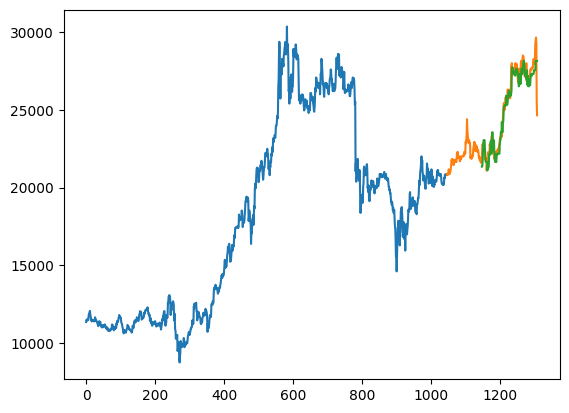

In [ ]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred)

plt.plot(prediect_data_index,scaler.inverse_transform(np.array(lst_output).reshape(-1,1)))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [ ]:
#Dự đoán 60 ngày tiếp theo
x_input = test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = time_step
i = 0
pred_days = 60
while(i < pred_days):
    
    if(len(temp_input) > time_step):
        
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        
        yhat = model.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i = i+1
        
    else:
        yhat = model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i = i+1
        
print("Output of predicted next days: ", lst_output)

1 day output [0.74392676]
2 day output [0.7587594]
3 day output [0.76101255]
4 day output [0.76101255]
5 day output [0.76101255]
6 day output [0.76101255]
7 day output [0.76101255]
8 day output [0.76101255]
9 day output [0.76101255]
10 day output [0.76101255]
11 day output [0.76101255]
12 day output [0.76101255]
13 day output [0.76101255]
14 day output [0.76101255]
15 day output [0.76101255]
16 day output [0.76101255]
17 day output [0.76101255]
18 day output [0.76101255]
19 day output [0.76101255]
20 day output [0.76101255]
21 day output [0.76101255]
22 day output [0.76101255]
23 day output [0.7479114]
24 day output [0.7479114]
25 day output [0.7479114]
26 day output [0.76101255]
27 day output [0.76101255]
28 day output [0.76101255]
29 day output [0.76101255]
30 day output [0.76101255]
31 day output [0.76101255]
32 day output [0.76101255]
33 day output [0.76101255]
34 day output [0.76101255]
35 day output [0.7479114]
36 day output [0.7479114]
37 day output [0.7479114]
38 day output [0.

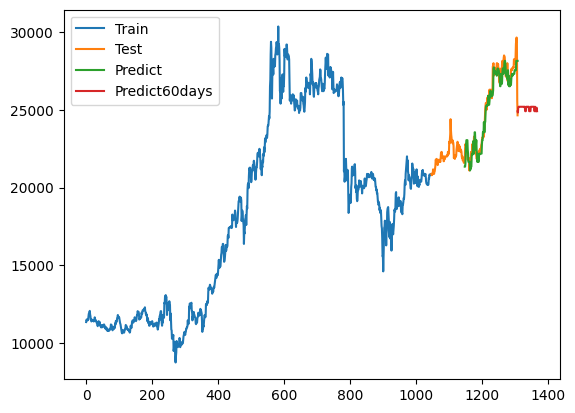

In [ ]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)-1+len(scaler.inverse_transform(np.array(lst_output).reshape(-1,1))), step=1)
plt.plot(prediect_data_index, scaler.inverse_transform(np.array(lst_output).reshape(-1,1)))

plt.legend(['Train', 'Test', 'Predict', 'Predict60days'])
plt.show()

In [ ]:
#Dự đoán 90 ngày tiếp theo
x_input = test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = time_step
i = 0
pred_days = 90
while(i < pred_days):
    
    if(len(temp_input) > time_step):
        
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        
        yhat = model.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i = i+1
        
    else:
        yhat = model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i = i+1
        
print("Output of predicted next days: ", lst_output)

1 day output [0.74392676]
2 day output [0.7587594]
3 day output [0.76101255]
4 day output [0.76101255]
5 day output [0.76101255]
6 day output [0.76101255]
7 day output [0.76101255]
8 day output [0.76101255]
9 day output [0.76101255]
10 day output [0.76101255]
11 day output [0.76101255]
12 day output [0.76101255]
13 day output [0.76101255]
14 day output [0.76101255]
15 day output [0.76101255]
16 day output [0.76101255]
17 day output [0.76101255]
18 day output [0.76101255]
19 day output [0.76101255]
20 day output [0.76101255]
21 day output [0.76101255]
22 day output [0.76101255]
23 day output [0.7479114]
24 day output [0.7479114]
25 day output [0.7479114]
26 day output [0.76101255]
27 day output [0.76101255]
28 day output [0.76101255]
29 day output [0.76101255]
30 day output [0.76101255]
31 day output [0.76101255]
32 day output [0.76101255]
33 day output [0.76101255]
34 day output [0.76101255]
35 day output [0.7479114]
36 day output [0.7479114]
37 day output [0.7479114]
38 day output [0.

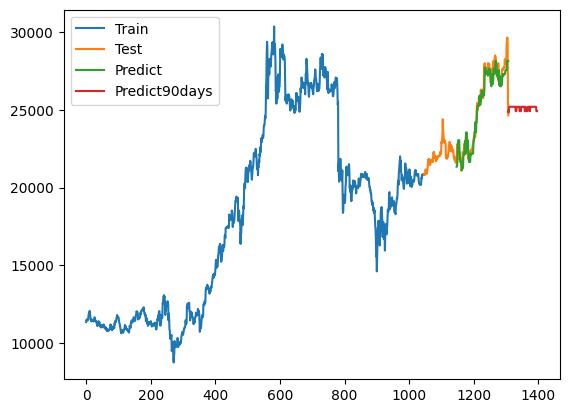

In [ ]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)-1+len(scaler.inverse_transform(np.array(lst_output).reshape(-1,1))), step=1)
plt.plot(prediect_data_index, scaler.inverse_transform(np.array(lst_output).reshape(-1,1)))

plt.legend(['Train', 'Test', 'Predict', 'Predict90days'])
plt.show()